<a href="https://colab.research.google.com/github/brito-bernardo/osmnx/blob/main/CycleWaysAndBusStops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 3.4 MB/s eta 0:00:00


In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt


In [3]:
place_name = "Porto, Portugal"

G = ox.graph_from_place(place_name, network_type = 'all')

In [4]:
tags = {'highway': 'bus_stop'}
bus_stops = ox.geometries_from_place(place_name, tags=tags)

<ipython-input-4-70b09b3fff53>:2: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bus_stops = ox.geometries_from_place(place_name, tags=tags)


In [6]:
bus_stops_buffer = bus_stops.to_crs('EPSG:3395').buffer(100).to_crs('EPSG:4326')


intersections = ox.graph_to_gdfs(G, nodes=True, edges=False)


near_bus_stops = intersections[intersections.geometry.apply(lambda x: bus_stops_buffer.contains(x).any())]

In [9]:
def is_bike_friendly(edge):
    # Checks for bike-friendly infrastructure or allowances
    return (
        edge.get('bicycle', 'no') in ('yes', 'designated', 'permissive') or
        edge.get('highway') == 'cycleway' or
        'cycleway' in edge
    )

<ipython-input-16-520d40fd3efc>:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


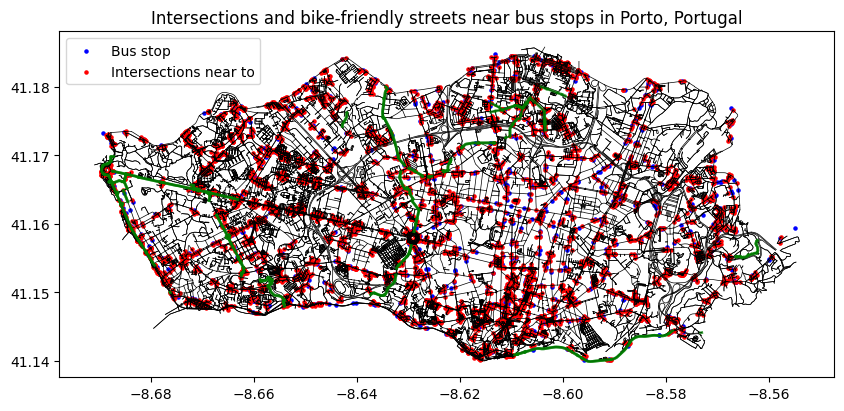

In [16]:
#Logical thinking of this code and plotting graphics


fig, ax = plt.subplots(figsize=(10, 10))

# Only edges
for _, edge in ox.graph_to_gdfs(G, nodes=False, edges=True).iterrows():
    line = edge.geometry
    x, y = line.xy
    ax.plot(x, y, color="black", linewidth=0.5)

bus_stops.plot(ax=ax, color='blue', markersize=5, label='Bus stop')
near_bus_stops.plot(ax=ax, color='red', markersize=5, label='Intersections near to')

# Get all the edges
_, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
bike_friendly_edges = edges[edges.apply(is_bike_friendly, axis=1)]

if bike_friendly_edges.empty:
    print("No bike-friendly paths found. The data might not include them or the filtering criteria might be too strict.")
else:
    for _, edge in bike_friendly_edges.iterrows():
        line = edge['geometry']
        x, y = line.xy
        ax.plot(x, y, color='green', linewidth=2, alpha=0.7)

ax.set_title("Intersections and bike-friendly streets near bus stops in {}".format(place_name))
plt.legend()
plt.show()

In [17]:
import geopandas as gpd

In [18]:
# Retrieve the bike-friendly edges as before.
bike_friendly_edges = edges[edges.apply(is_bike_friendly, axis=1)]

# Convert the bike-friendly edges to the same metric CRS that you used for bus_stops
bike_friendly_edges = bike_friendly_edges.to_crs('EPSG:3395')

# Create a buffer around the bike-friendly edges, using the same metric CRS
bike_friendly_buffer = bike_friendly_edges.buffer(20)

# Get back to the same CRS method for easy plotting.
bike_friendly_buffer = bike_friendly_buffer.to_crs('EPSG:4326')

# Filtering using the previous buffer for bus_stops and near_bus_stops.
bus_stops_near_bike_friendly = bus_stops[bus_stops.geometry.within(bike_friendly_buffer.unary_union)]
near_bus_stops_near_bike_friendly = near_bus_stops[near_bus_stops.geometry.within(bike_friendly_buffer.unary_union)]

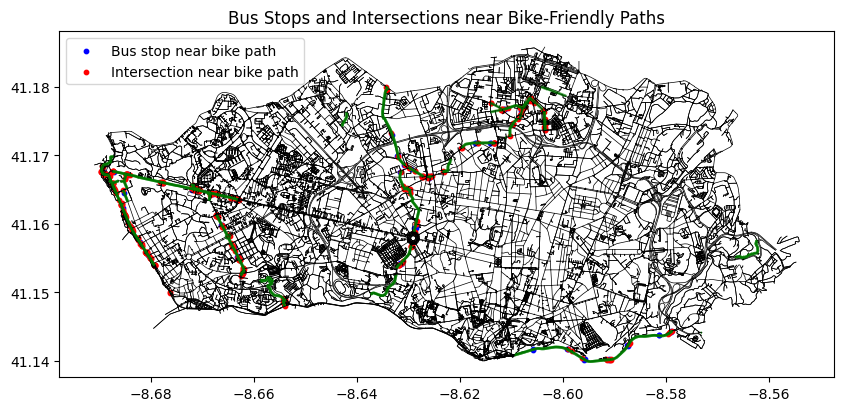

In [19]:
#Plotting all same stuff
fig, ax = plt.subplots(figsize=(10, 10))

for _, edge in ox.graph_to_gdfs(G, nodes=False, edges=True).iterrows():
    line = edge.geometry
    x, y = line.xy
    ax.plot(x, y, color="black", linewidth=0.5)

bus_stops_near_bike_friendly.plot(ax=ax, color='blue', markersize=10, label='Bus stop near bike path')

near_bus_stops_near_bike_friendly.plot(ax=ax, color='red', markersize=10, label='Intersection near bike path')

bike_friendly_edges.to_crs('EPSG:4326').plot(ax=ax, color='green', linewidth=2, alpha=0.7)

ax.set_title("Bus Stops and Intersections near Bike-Friendly Paths")
plt.legend()
plt.show()